## This notebook does the scene prediction loop:
1. Predict a scene given a pose
2. Estimate the pose given the predicted scene
3. Predict a new scene given the estimated pose

In [92]:
from dataset import SiTDataset
from tqdm import tqdm
import os
os.environ['PYTHONPATH'] = '/env/python:/content/SiT'
import torch
from torchvision.utils import save_image
from transport import create_transport, Sampler
from diffusers.models import AutoencoderKL
from download import find_model
from models import SiT_S_2, SiT_B_8
import lpips
from PIL import Image
import numpy as np
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [93]:
psnr = PeakSignalNoiseRatio(data_range=255).cuda()
lpips = LearnedPerceptualImagePatchSimilarity(net_type='squeeze').cuda()

def get_pose_radius(pose):
    translation_vector = pose[:3, 3]
    radius = torch.norm(translation_vector)
    
    return radius

def evaluate_prediction(ground_truth, prediction):
    ground_truth = ground_truth.clamp(0, 255)
    prediction = prediction.clamp(0, 255)
    
    psnr_value = psnr(prediction, ground_truth) #(N,C,H,W)

    mae = torch.mean(torch.abs(ground_truth - prediction))

    ground_truth = ground_truth.div(255.0).mul(2).sub(1).clamp(-1, 1)
    prediction = prediction.div(255.0).mul(2).sub(1).clamp(-1, 1)

    lpips_value = lpips(prediction, ground_truth)

    return psnr_value.item(), lpips_value.item(), mae.item()

def extract_original_pose(denoised_pose, rot_mean, rot_std, trans_mean, trans_std):

    stdized_pose_flat = []

    for i in range(4):
        first = torch.mean(denoised_pose[i, :8, :8])
        second = torch.mean(denoised_pose[i, :8, 8:])
        third = torch.mean(denoised_pose[i, 8:, :8])
        fourth = torch.mean(denoised_pose[i, 8:, 8:])
        stdized_pose_flat.extend([first, second, third, fourth])

    stdized_pose_tensor = torch.stack(stdized_pose_flat)

    original_flat = stdized_pose_tensor.clone()

    rot_indices = [0, 1, 2, 4, 5, 6, 8, 9, 10]
    trans_indices = [3, 7, 11]

    R_std = stdized_pose_tensor[rot_indices]
    t_std = stdized_pose_tensor[trans_indices]
    R = R_std * rot_std + rot_mean
    t = t_std * trans_std + trans_mean

    for i, idx in enumerate(rot_indices):
        original_flat[idx] = R[i]
    for i, idx in enumerate(trans_indices):
        original_flat[idx] = t[i]

    original_flat[12:16] = torch.tensor([0., 0., 0., 1.], dtype=original_flat.dtype)

    pose_4x4 = original_flat.view(4, 4)

    return pose_4x4

def calculate_translation_error(ground_truth, prediction):
    prediction = prediction.to("cuda")
    ground_truth_translation = ground_truth[0:3, 3]
    prediction_translation = prediction[0:3, 3]
    
    distance = torch.norm(ground_truth - prediction) 

    return distance.item()

def calculate_rotation_error(ground_truth, prediction):
    ground_truth = ground_truth.to("cuda")
    prediction = prediction.to("cuda")
    
    ground_truth_rotation = ground_truth[:3, :3]
    prediction_rotation = prediction[:3, :3]
    prediction_rotation = prediction_rotation.type(torch.FloatTensor).to("cuda")

    dot_product = ground_truth_rotation.T @ prediction_rotation

    trace = torch.trace(dot_product)

    cos_arg = torch.clamp((trace - 1) / 2, -1.0, 1.0)

    result = torch.acos(cos_arg)

    result_deg = torch.rad2deg(result)

    return result_deg.item()

def evaluate_poses(ground_truth, prediction):

    translation_error = calculate_translation_error(ground_truth, prediction)

    rotation_error = calculate_rotation_error(ground_truth, prediction)
    
    return translation_error, rotation_error

def draw_coordinate_frame(ax, pose, length=0.5, color_set=('r', 'g', 'b')):

    origin = pose[:3, 3]
    x_axis = pose[:3, 0] * length
    y_axis = pose[:3, 1] * length
    z_axis = pose[:3, 2] * length

    ax.quiver(*origin, *x_axis, color=color_set[0])
    ax.quiver(*origin, *y_axis, color=color_set[1])
    ax.quiver(*origin, *z_axis, color=color_set[2])

def visualize_poses(gt_poses, pred_poses):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    gt_origins = []
    pred_origins = []

    # Draw GT poses
    for pose in gt_poses:
        draw_coordinate_frame(ax, pose, color_set=('cyan', 'blue', 'navy'))
        gt_origins.append(pose[:3, 3])

    # Draw predicted poses
    for pose in pred_poses:
        draw_coordinate_frame(ax, pose, color_set=('orange', 'red', 'darkred'))
        pred_origins.append(pose[:3, 3])

    gt_origins = np.array(gt_origins)
    pred_origins = np.array(pred_origins)

    ax.scatter(gt_origins[:, 0], gt_origins[:, 1], gt_origins[:, 2],
               c='blue', s=25, label='Ground Truth')
    ax.scatter(pred_origins[:, 0], pred_origins[:, 1], pred_origins[:, 2],
               c='red', s=25, label='Predicted')

    ax.set_xlim([-7, 7])
    ax.set_ylim([-7, 7])
    ax.set_zlim([-7, 7])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("Ground Truth vs Predicted Poses")
    ax.view_init(elev=35, azim=50)
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    return gt_poses, pred_poses


In [94]:
image_size = "128"
vae_model = "stabilityai/sd-vae-ft-ema"
latent_size = int(image_size) // 8

model = SiT_B_8(input_size=latent_size, num_classes=1).to('cuda')
state_dict = find_model("results/001-SiT-B-8-Linear-velocity-None/checkpoints/0090000.pt")                # Print the actual tensor (can be large!)
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to('cuda')


In [95]:
#seed = 1 #@param {type:"number"}
#torch.manual_seed(seed)

num_sampling_steps = 250

cfg_scale = 4

class_labels = [0]
sampler_type = "ODE"

transport = create_transport()
sampler = Sampler(transport)

In [96]:
# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler"
    diffusion_form = "linear"
    
    """This tells how strong the noise is"""
    diffusion_norm = 1
    
    """How the final denoised latent should be calculated"""
    last_step = "Mean"
    last_step_size = 0.4
    
    """Final function at the end that does everything:
    """
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form, 
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size, 
        num_steps=num_sampling_steps,
    )
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5"

    atol = 1e-6
    rtol = 1e-3
    
    sample_fn = sampler.sample_ode(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps
    )

In [98]:
from torchvision import transforms
from torch.utils.data import DataLoader

vae = AutoencoderKL.from_pretrained(vae_model).to("cuda")

device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1], inplace=True)
])

train_dataset = SiTDataset("data/chair_data/train", transform=transform)
rot_mean = torch.Tensor(train_dataset.rotation_mean).to("cuda")
rot_std = torch.Tensor(train_dataset.rotation_std).to("cuda")
trans_mean = torch.Tensor(train_dataset.translation_mean).to("cuda")
trans_std = torch.Tensor(train_dataset.translation_std).to("cuda")

dataset = SiTDataset("data/chair_data/test_div", transform=transform)

eval_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

ys = torch.zeros(1, dtype=torch.long, device="cuda")

In [99]:
from torchvision.utils import save_image
import torch
from tqdm import tqdm
import random

max_pairs = 1                    # how many GT/pred rows to keep
gt_pool, pred_pool = [], []       # hold first 10 pairs for final sheet

plot_data = []
radii = []
i = 0
img_1_idx = random.randint(0, 1000)

image_og, gaussian_pose_og, gt_pose_og, noise_og = dataset.__getitem__(img_1_idx)
image_og, gaussian_pose_og, gt_pose_og, noise_og = image_og.unsqueeze(0), gaussian_pose_og.unsqueeze(0), torch.Tensor(gt_pose_og), noise_og

with torch.inference_mode():
    image = image_og.to("cuda")
    gaussian_pose  = gaussian_pose_og.to("cuda")

    n = ys.size(0)
    y = torch.IntTensor([0]).to(device)
    z = torch.cat([gaussian_pose, gaussian_pose], 0)
    y_null = torch.tensor([1] * n, device="cuda")
    y = torch.cat([y, y_null], 0)
    model_kwargs = dict(y=y, cfg_scale=cfg_scale)

    samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[-1]
    samples = vae.decode(samples / 0.18215).sample
    
    samples = samples[0, :, :, :].unsqueeze(0)

    reconstructed_image_1 = samples

    print(image.shape)
    print(samples.shape)
    
    psnr_value, lpips_value, mae = evaluate_prediction(image, reconstructed_image_1)
    
    gt_pool.append(image[0].cpu())
    pred_pool.append(reconstructed_image_1[0].cpu())

    print("PSNR:", psnr_value)
    print("lpips_value:", lpips_value)
    print("mae:", mae)

if gt_pool:
    sheet_images = torch.stack(
        [im for pair in zip(gt_pool, pred_pool) for im in pair]
    ) 

    save_image(
        sheet_images,
        "first_reconstruction.png",
        nrow=2,
        padding=2,
        normalize=True,
        value_range=(-1, 1)
    )

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
PSNR: 55.1042594909668
lpips_value: 0.0009655281319282949
mae: 0.323942631483078


In [ ]:
# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler"
    diffusion_form = "linear"
    
    """This tells how strong the noise is"""
    diffusion_norm = 1
    
    """How the final denoised latent should be calculated"""
    last_step = "Mean"
    last_step_size = 0.4
    
    """Final function at the end that does everything:
    """
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form, 
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size, 
        num_steps=num_sampling_steps,
        reverse=True
    )
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5" 

    atol = 1e-6
    rtol = 1e-3
    
    sample_fn = sampler.sample_ode_backwards(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps
    )

In [101]:
#Iterate over testset loader, get image, pose
total_translation_error = 0
total_rotation_error = 0
plot_data = []
pose_gt = []
pose_pred = []

with torch.inference_mode():
    noise = noise_og.to("cuda")
    gt_pose = gt_pose_og.to("cuda")
    image = reconstructed_image.to("cuda")
    
    posterior = vae.encode(image)[0]
    image = posterior.sample()
    image = image * 0.18215
    
    n = ys.size(0)
    y = torch.IntTensor([0]).to(device)
    z = torch.cat([image, image], 0)
    y_null = torch.tensor([1] * n, device="cuda")
    
    y = torch.cat([y, y_null], 0)
    model_kwargs = dict(y=y, cfg_scale=cfg_scale)
    
    samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[-1]

    print(noise.shape)

    noisy_pose = samples

    print(samples.shape)
    
    denoised_pose = samples - noise

    reconstructed_pose = extract_original_pose(denoised_pose, rot_mean, rot_std, trans_mean, trans_std)
    
    pose_pred.append(reconstructed_pose.cpu().detach().numpy())
    pose_gt.append(gt_pose.cpu().detach().numpy())

    print(gt_pose.shape)
    print(reconstructed_pose.shape)
    
    translation_error, rotation_error = evaluate_poses(gt_pose, reconstructed_pose)

print("translation error:", translation_error)
print("rotation_error:", rotation_error)

torch.Size([4, 16, 16])
torch.Size([4, 16, 16])
torch.Size([4, 4])
torch.Size([4, 4])
translation error: 3.5900280475616455
rotation_error: 18.911027908325195


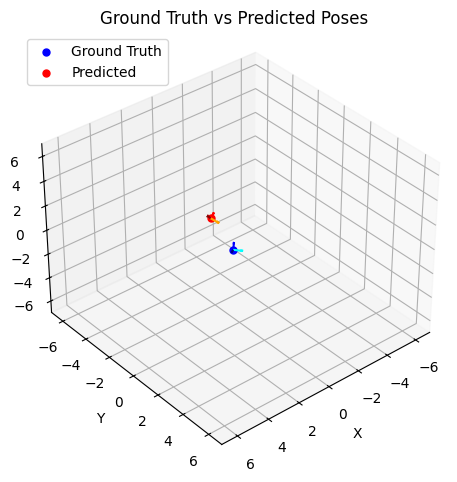

([array([[-0.6334774 , -0.31050467,  0.7087265 ,  1.3045635 ],
         [ 0.7737613 , -0.2542098 ,  0.5802335 ,  1.0680445 ],
         [ 0.        ,  0.91594994,  0.4012926 ,  0.7386653 ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]],
        dtype=float32)],
 [array([[-1.0798192e-01, -4.7978616e-01,  7.4057603e-01,  2.5841599e+00],
         [ 1.1924587e+00, -5.4218821e-02,  3.8028863e-01,  8.6382437e-01],
         [ 8.8292582e-09,  5.9880579e-01,  1.1069396e+00,  3.9087777e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
        dtype=float32)])

In [102]:
visualize_poses(pose_gt, pose_pred)

In [103]:
ODE_sampling_method = "dopri5"

atol = 1e-6
rtol = 1e-3

sample_fn = sampler.sample_ode(
    sampling_method=ODE_sampling_method,
    atol=atol,
    rtol=rtol,
    num_steps=num_sampling_steps
)

In [104]:

max_pairs = 1
gt_pool, pred_pool = [], []

plot_data = []
radii = []
i = 0

with torch.inference_mode():
    image = image_og.to("cuda")
    gaussian_pose  = noisy_pose.to("cuda").unsqueeze(0)

    print(gaussian_pose.shape)

    n = ys.size(0)
    y = torch.IntTensor([0]).to(device)
    z = torch.cat([gaussian_pose, gaussian_pose], 0)
    y_null = torch.tensor([1] * n, device="cuda")
    y = torch.cat([y, y_null], 0)
    model_kwargs = dict(y=y, cfg_scale=cfg_scale)

    samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[-1]
    samples = vae.decode(samples / 0.18215).sample
    
    samples = samples[0].unsqueeze(0)

    reconstructed_image_2 = samples

    print(image.shape)
    
    psnr_value, lpips_value, mae = evaluate_prediction(image, reconstructed_image_2)
    
    gt_pool.append(image[0].cpu())
    pred_pool.append(reconstructed_image_2[0].cpu())

    print("PSNR:", psnr_value)
    print("lpips_value:", lpips_value)
    print("mae:", mae)

if gt_pool:
    sheet_images = torch.stack(
        [im for pair in zip(gt_pool, pred_pool) for im in pair]
    ) 

    save_image(
        sheet_images,
        "second_reconstruction.png",
        nrow=2,
        padding=2,
        normalize=True,
        value_range=(-1, 1)
    )

torch.Size([1, 4, 16, 16])
torch.Size([1, 3, 128, 128])
PSNR: 54.11264419555664
lpips_value: 0.0013646949082612991
mae: 0.3962930142879486
